# Rule-based control of the solar home (Julia)

This is the simplest control scheme of the solar home, implemented in Julia. It can be used as an example of how to use the solar home test bench in this language. Rule-based control yields a good baseline performance for comparing more advanced energy management methods.

See also:
* [Python_rule-based.ipynb](../python_rule-based/Python_rule-based.ipynb): an equivalent example in Python

Pierre Haessig, July 2019

In [1]:
using Printf, Statistics
# Plotting:
using PyPlot

Import solarhome utility module `Benchutils`, using `bu` as a short alias.

In [2]:
p_utils = joinpath("..","..","utils")
@assert isdir(p_utils)
push!(LOAD_PATH, p_utils)

import Benchutils
const bu = Benchutils

Benchutils

## 1. Load solar home test data

In [3]:
params, data = bu.load_data(subset="test");

loading test data (2011-11-29 00:00:00 to 2011-12-28 23:30:00)

### Solar home parameters

In [4]:
E_rated = params.E_rated
P_pvp = params.P_pvp
P_grid_max = params.P_grid_max

println("E_rated: $E_rated kWh")
println("P_pvp: $P_pvp kWp")
println("P_grid_max: $P_grid_max kW")

E_rated: 8.0 kWh
P_pvp: 4.0 kWp
P_grid_max: 3.0 kW


### Solar home time series

time vectors

In [5]:
t = data["t"]
dt = t[2] - t[1]
td = t/24; # days

In [6]:
n = length(t)
ndays = Int(n/48) # days
ndays

30

In [7]:
P_load = data["P_load_sp"]
# scaling of PV production
P_sun = data["P_sun_1k"]*P_pvp
c_grid = data["c_grid"];

In [8]:
@printf("Average sun energy: %.2f kWh/d\n", mean(P_sun)*24)
@printf("Average load      : %.2f kWh/d\n", mean(P_load)*24)
@printf("ratio sun/load: %.1f%%", mean(P_sun)/mean(P_load)*100)

Average sun energy: 15.60 kWh/d
Average load      : 17.02 kWh/d
ratio sun/load: 91.7%

Demo plot of input data

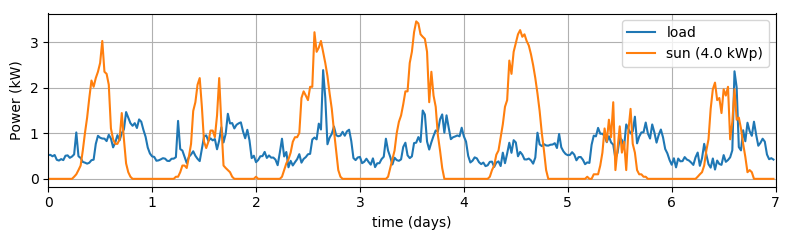

In [9]:
fig, ax = plt.subplots(1,1, figsize=(8,2.5))
z = 1:7*48
ax.plot(td[z], P_load[z], label="load", color="tab:blue")
ax.plot(td[z], P_sun[z], label="sun ($P_pvp kWp)", color="tab:orange")

ax.legend()
ax.grid(true)

ax.set(
    xlim = (0,7),
    xlabel = "time (days)",
    ylabel = "Power (kW)"   
)
fig.tight_layout()

## 2. Rule based control

control rules:

* storage should follow the net load as much as possible: $P_{sto} = -P_{nl} = P_{sun} - P_{load} $
* if empty, use grid instead
* if full, curtail the excess of production

inputs: $P_{sun}$, $P_{load}$ and storage state $E_{sto}$

Outputs: $P_{sto}$, $P_{grid}$, $P_{curt}$

def: net load: $P_{nl} = P_{load} - P_{sun}$

* if $P_{nl}>0$ (load > sun)
  * if battery not empty: battery discharge to follow net load $P_{sto} = -P_{nl} <0 $, $P_{grid} = 0$.
  * if battery is empty, use the grid instead: $P_{grid} = P_{nl}$
* if $P_{nl}<0$ (sun > load)
  * if battery not full: battery charges to absorbe net production $P_{sto} = -P_{nl} > 0$, $P_{grid} = 0$.
  * if battery is full, curtail the excess of production: $P_{curt} = -P_{nl}$, so that $P_{sun} - P_{curt} = P_{pv} = P_{load}$. $P_{grid} = 0$

In [10]:
function control(P_sun, P_load, E_sto)
    P_nl = P_load - P_sun
    # outputs:
    P_sto = 0.
    P_grid = 0.
    P_curt = 0.
    
    E_next = E_sto - P_nl*dt
    
    if P_nl>0 # (load > sun)
        E_next = if E_next>0. E_next else 0. end
        P_sto = (E_next - E_sto)/dt # <0
        P_grid = P_nl + P_sto
    else
        E_next = if E_next<E_rated E_next  else E_rated end
        P_sto = (E_next - E_sto)/dt # >0
        P_curt = -P_nl - P_sto
    end
    return P_sto, P_grid, P_curt
end

control (generic function with 1 method)

In [11]:
control(1,3, 5)

(-2.0, 0.0, 0.0)

In [12]:
control(1,3, 0)

(0.0, 2.0, 0.0)

In [13]:
control(1,3, 0.1*dt)

(-0.1, 1.9, 0.0)

In [14]:
control(3,1, 5)

(2.0, 0.0, 0.0)

In [15]:
control(3,1, E_rated)

(0.0, 0.0, 2.0)

In [16]:
control(3,1, E_rated-0.1*dt)

(0.09999999999999964, 0.0, 1.9000000000000004)

## 3. Solar home simulation

In [17]:
P_sto = zeros(n)
E_sto = zeros(n+1)
P_grid = zeros(n)
P_curt = zeros(n)

E_sto[1]= E_rated/2

for k in 1:n
    P_sto[k], P_grid[k], P_curt[k] = control(P_sun[k], P_load[k], E_sto[k])
    E_sto[k+1] = E_sto[k] + P_sto[k]*dt
    @assert 0 <= E_sto[k+1] <= E_rated
end
    
E_sto = E_sto[1:end-1]
P_pv = P_sun - P_curt
P_nl = P_load - P_sun;

Collect all trajectory variables

In [18]:
traj = Dict(
    "E_sto" => E_sto, # state 
    "P_sto" => P_sto, # out

    "P_load_sp" => P_load,
    "P_shed" => zero(P_load),
    "P_load" => P_load,

    "P_sun"  => P_sun,
    "P_curt" => P_curt,
    "P_pv"   => P_sun - P_curt,

    "P_grid" => P_grid,
    "c_grid" => c_grid,
);

### Performance statistics

In [19]:
stats = bu.compute_stats(traj)
bu.pprint_stats(stats)

P_load:    17.02 kWh/d

P_sun:     15.60 kWh/d (data)
P_curt:     1.94 kWh/d
P_pv:      13.66 kWh/d

P_sto:      0.03 kWh/d

P_grid:     3.38 kWh/d
C_grid:    0.563 €/d


### Plots

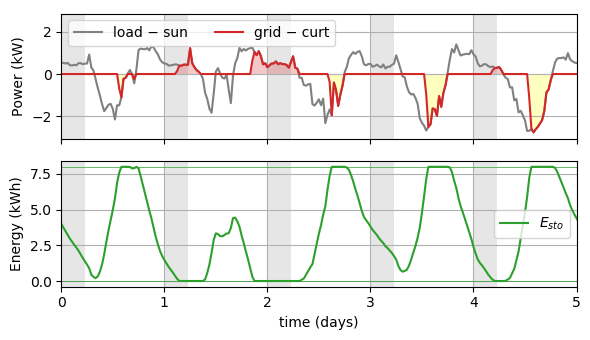

In [20]:
fig, ax = bu.plot_traj(traj, E_rated)
ax[1].set_xlim(0, 5);

### Save results in CSV files

In [21]:
bu.save_results("Julia_rule-based", params, data, stats, traj)

result files for method "Julia_rule-based" written!


## 4. Performance uncertainty evaluation with bootstrapped inputs

TO BE DONE:
1. add the ability to load boostrapped samples in `Benchutils.load_data`)
2. put the simulation loop in a function